<h2> 0. Intro </h2>

<h7>지금까지 RNN의 이론에 대해서 전반적으로 살펴보았다. 이제 연습문제들을 통해서 RNN에 대한 조금 더 깊이 있는 이해를 시도해보자.

0과 1로 구성된 수열의 홀짝 여부를 판단하는 문제를 다룰것이다. 수열 안에 포함된 1의 개수를 기준으로 1의 개수가 홀수면 홀, 짝수면 짝으로 분류하는 문제이다.
```
    (0,0,1,0,0,0) 은 홀
```
```
    (0,0,1,0,1,0) 은 짝
```
이런식으로 본 연습문제에서는 입력받은 수열의 홀짝 여부를 판정해주는 모델을 구축해볼 것이다. 모델을 구축하기 위해서는 학습 과정이 반드시 선행되어야 할 것이다. 본 문제에서는 어떠한 과정을 거쳐서 최종적으로 모델을 구축할 수 있는지에 대해 알아보도록 하겠다.

연습문제를 진행하기에 앞서 진행에 필요한 라이브러리들을 import해보자.</h7>

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

%matplotlib inline


<h2>1. 데이터셋 생성 함수 구현</h2>

<h7>위에 설명한 바, 모델을 구축하기 위해서는 학습이 진행되어야 한다. 그리고 학습을 진행시키기 위해서는 학습에 쓸 데이터셋을 먼저 생성해주어야 할 것이다.

고로 학습에 필요한 데이터셋을 생성해주는 함수 generate_dataset를 구현해보자. 이 함수는 N과 T, 2가지 변수를 입력받아서, x와 y, 두 배열을 출력하는 함수이다. 여기서 출력값인 x, y가 나타내는 것은 아래와 같다.</h7>

* x : 각 원소마다 동등한 확률로 0 혹은 1의 값을 갖는 (N, T) 모양의 2차원 Numpy 배열
* y : (N, ) 모양의 1차원 Numpy 배열로, 은 x의 i번째 행에 포함된 1의 개수가 짝수이면 1, 홀수이면 0의 값을 갖는다.

<h7>여기서 N은 batch의 크기를, T는 0과 1로 구성된 수열의 길이를 지칭한다.</h7>

<h7>아래의 예시를 통해, 출력값 x, y가 나타내는 바가 정확히 무엇인지 좀 더 자세히 들여다보자.

예를 들어, generate_dataset(4, 8)이라고 입력했다면, 출력 값으로 4개의 벡터가 생성될 것이다. 그리고 벡터 각각은 0과 1로 구성되어 있는 길이 8의 수열을 나타낼 것이다. 해당 함수에서 생성될 x 값을 예시로 한 가지 들어보자면 아래와 같을 것이다.</h7>

In [ ]:
[[1., 0., 1., 1., 0., 1., 1., 1.],
[0., 1., 1., 1., 0., 1., 0., 1.],
[0., 1., 0., 1., 0., 1., 0., 0.],
[0., 1., 1., 0., 0., 1., 1., 1.]]

[[1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0],
 [0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0],
 [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]]

<h7>그리고 이에 대응되는 y 값은 아래와 같을 것이다.</h7>

In [ ]:
[1, 0, 0, 0]

[1, 0, 0, 0]

<h7>
**Note** : 이렇게 생성된 x의 경우, 서로 다른 행이 동일한 값을 가질 수도 있다. 단순히 확률에 의존하여 생성된 데이터이기에 동일한 행이 존재하는 것은 당연히 벌어질 수 있는 상황이며, 수열의 길이가 길어질수록 중복되는 행이 존재할 확률은 줄어들게 될 것이다.
자, 지금까지 generate_dataset의 함수가 무엇을 입력받아서 어떤 값을 출력하는 함수인지 살펴보았다. 이제 본격적으로 generate_dataset 함수를 구현해보도록 하자.
</h7>

In [ ]:

def generate_dataset(N, T):
    """
    매개변수(Parameters)
    ----------
    N : int
    생성하고자 하는 수열의 개수
    T : int
    생성하고자 하는 수열의 길이

    반환 값(Returns)
    -------
    Tuple[numpy.ndarray, numpy.ndarray], shapes - (N, T) & (N, )
    Tuple은 다음을 포함하고 있다
    - 수열들로 구성된 batch; shape - (N, T)
    - 각 수열에 대응되는 라벨 : 1의 개수가 짝수면 1, 홀수면 0; shape - (N, )
    """
    # 여기에 코드 작성
    x = np.random.choice([0,1], (N,T)).astype(np.int_)
    y = (x.sum(axis = 1) % 2).astype(np.int_)

    return x, y

<h7>이제 generate_dataset 함수를 구현했으니, 의도한 대로 구현이 잘 되었는지 테스트를 해보도록 하자. 위에서 함수 설명하는 데 예시로 사용했던 대로, 길이 8의 수열을 4개 생성해볼 것이다. 생성한 다음, 각 수열들이 의도한 형태대로 잘 생성되었는지, 각 수열에 대응되는 라벨들은 해당 수열의 홀짝 여부를 고스란히 잘 나타내고 있는지, 두 가지에 대해서 확인해보자.</h7>

In [ ]:
# 여기에 코드 작성
x, y = generate_dataset(4, 8)
print(x)
print(y)
print(x.shape)
print(y.shape)

[[0 0 0 1 1 0 1 1]
 [1 1 1 0 1 1 1 1]
 [0 0 0 1 0 1 1 1]
 [0 1 1 0 0 1 1 1]]
[0 1 0 1]
(4, 8)
(4,)


<h2>2. 학습을 위한 데이터셋 생성</h2>

<h7>이제 본격적으로 데이터셋을 생성해볼 것이다. 우리는 두 가지 데이터셋이 필요하다. 하나는 신경망에 학습을 시키기 위해 필요한 학습용 데이터셋이고, 다른 하나는 신경망의 정확도를 측정하기 위한 테스트용 데이터셋이다. 테스트용 데이터셋의 경우, 해당 신경망이 훈련된 데이터들뿐만 아니라 임의의 새로운 데이터가 입력이 되었을 경우에도 정확하게 작동하는지 확인하기 위한 데이터셋이다. 그렇기 때문에 학습용 데이터셋과 테스트용 데이터셋은 각각 별도로 생성해 주어야 할 것이다.

이제 10000개의 행과 32개의 열로 이루어진 데이터셋을 생성해보자. 이 데이터셋을 절반으로 나눠서 학습용 데이터셋과 테스트용 데이터셋으로 구분지어 보자.</h7>

In [ ]:
# 여기에 코드 작성
x, y = generate_dataset(10000, 32)
xtrain = torch.tensor(x[:5000], dtype=torch.float32)
ytrain = torch.tensor(y[:5000], dtype=torch.long)
xtest = torch.tensor(x[5000:], dtype=torch.float32)
ytest = torch.tensor(y[5000:], dtype=torch.long)

<h7>학습용 데이터셋과 테스트용 데이터셋의 형태를 출력해보자. 열의 개수와 행의 개수가 의도한 대로 잘 짜여 있는지 확인해보도록 하자.</h7>

In [ ]:
# 여기에 코드 작성
print(f'x_train Shape : {xtrain.shape}')
print(f'Y_train Shape : {ytrain.shape}')

print(f'x_test Shape : {xtest.shape}')
print(f'Y_test Shape : {ytest.shape}')

print(f'xtrain[0,:] : {xtrain[0,:]}')
print(f'ytrain[0] : {ytrain[0]}')

x_train Shape : torch.Size([5000, 32])
Y_train Shape : torch.Size([5000])
x_test Shape : torch.Size([5000, 32])
Y_test Shape : torch.Size([5000])
xtrain[0,:] : tensor([0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.])
ytrain[0] : 1


<h2>3. My Model 모델 정의하기</h2>

<h7>위에서 만든 데이터셋을 학습시키기 위해 우리는 2개의 층으로 구성된 신경망을 구축할 것이다. 이를 함수의 형태로 표현해보자면, 아래와 같을 것이다.</h7>

$$ f(W_1, W_2, b_1, b_2; X) = softmax(ReLU(XW_1+b_1)W_2+b_2) $$

주어진 입력 값 $X$에 $W_1$을 곱하고, $b_1$를 더한 값에 ReLU 함수를 적용해서 첫 번째 층에 해당하는 연산을 진행한다. 그 값에 $W_2$를 곱하고, $b_2$를 더한 다음, softmax 함수를 적용한다. 이로써 2개 층에 해당하는 연산을 진행하게 된다.

**Note** : 왜 이러한 형식의 계산이 이루어지는 것일까? 만일 ReLU 함수와 softmax 함수가 존재하지 않는다고 가정해보자. 그렇다면 함수 f는 아래의 식과 같을 것이다.

$$f(W_1, W_2, b_1, b_2; X)=(XW_1+b_1)W_2+b_2=X(W_1W_2+b_1W_2)+b_2$$

즉 X에 대한 연산 과정이 단 한 번의 선형 연산으로 표현할 수 있게 되는 것이다. 즉, ReLU와 softmax와 같이 비선형적인 함수가 개입되지 않는다면 층의 개수가 아무리 많다고 하더라도 위와 같이 단 한 번의 선형 연산으로 표현될 수 있게 된다.

여러 개의 층으로 표현해주기 위해서는 ReLU와 softmax와 같은 비선형적인 함수를 도입해야 하며, 우리는 이러한 함수를 '활성화 함수'라고 부른다. 이 활성화 함수를 통해서 오로지 한 번의 선형 연산이 아닌 여러 차례의 복잡한 연산이 이루어지게 함으로써 주어진 입력 값 X의 여러 복잡한 규칙들을 찾아내는 것이다.

손실 함수는 위 연산을 통해 출력된 값을 입력받아 교차 엔트로피를 계산한 값을 출력한다. 교차 엔트로피가 무엇인지 잊었다면, 비전 모듈 4장의 더 알아보기를 참조하도록 하자. 교차 엔트로피를 계산하기 위해서 우리는 PyTorch 라이브러리에 있는 torch.nn.functional 함수를 이용할 것이다. 이 함수의 경우, softmax 함수를 내장하고 있기 때문에 softmax 함수는 연산에서 빼줄 것이다. 고로 우리가 계산할 값은 아래와 같다.

$$f(W_1, W_2, b_1, b_2; X)=ReLU(XW_1+b_1)W_2+b_2$$

이렇게 구축된 신경망은 궁극적으로 두 개의 분류 점수를 출력해준다 : $p_{old}$, $p_{new}$

**Note** : import torch.nn as nn을 통해 nn.init.normal_ 함수를 사용할 수 있도록 하자. 이 함수를 사용하여 W의 초깃값을 설정할 것이다.

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 우리의 My Model을 정의해보자!

class Model(nn.Module):
    def __init__(self, dim_in, num_hidden, dim_out):
        # 여기에 코드 작성
        super(Model, self).__init__()
        self.linear1 = nn.Linear(dim_in, num_hidden)
        self.linear2 = nn.Linear(num_hidden, dim_out)

        # weight를 normal로 초기화
        nn.init.normal_(self.linear1.weight, mean=0.0, std=1.0)
        nn.init.normal_(self.linear2.weight, mean=0.0, std=1.0)

    def __call__(self, x):
        """ 신경망의 순전파를 진행하는 함수를 구현해보자.
        매개변수(Parameters)
        ----------
        x : torch.Tensor, shape=(N, T)
        크기 N의 batch
        반환 값(Returns)
        -------
        torch.Tensor, shape=(N, 2)
        batch에 있는 N개의 수열들에 대한 예상 분류 점수
        """
        # 여기에 코드 작성
        x = F.relu(self.linear1(x))
        return self.linear2(x)

이제 구축한 모델과 optimizer를 가지고 학습시켜보자. 히든 레이어의 차원을 100으로 설정하자. 그리고 optimizer의 경우 SGD를 사용하며, learning_rate를 0.1로 설정해놓자.

In [ ]:
# 여기에 코드 작성
model = Model(dim_in = 32, num_hidden = 100, dim_out = 2)
optimizer = optim.SGD(model.parameters(), lr=0.1)
loss_func = nn.CrossEntropyLoss()

이제 신경망 예측의 정확도를 계산하는 함수를 구현해볼 것이다. 신경망이 예측한 값과 실제 라벨들을 비교해봄으로써 정확도를 계산해볼 것이다.


In [ ]:
def accuracy(predictions, truth):
    """
    하나의 batch에 대한 모델의 예측값과 실제값을 비교하여, 정확도를 계산하는 함수

    매개변수 (Parameters)
    ----------
    predictions : torch.Tensor, shape=(M, D)
        M은 batch를 구성하는 데이터의 개수, D는 분류할 소용돌이의 개수(이번 실습에서는 3으로 사용)
        Step 3에서 정의한 모델의 forward 메서드에서의 출력 인자 그대로가 이 함수에 전달된다고 생각

    truth : torch.Tensor, shape=(M,)
        batch를 구성하는 각각의 데이터(점)가 실제로 어떤 소용돌이에 포함되는지를 0, 1, ..., D-1의 숫자 중 하나로 나타내어 나열한 것
        예를 들어, batch에 3개의 데이터가 들어있고, 각각이 0번, 1번, 1번 소용돌이에 속한다면 truth는 [0, 1, 1]의 배열

    반환 값 (Returns)
    -------
    float형
        해당 batch에 대한 모델의 분류 정확도, 0 이상 1 이하의 실수값
    """
    # 개별 데이터에 대해, predictions에서 구해진 D개의 값 중 가장 큰 값의 인덱스 확인
    # 이 인덱스는 모델은 이 데이터가 어느 소용돌이에 속한다고 판단할지를 의미
    # 이 인덱스, 그리고 해당 데이터의 truth 값이 같은지, 다른지 확인
    predicted_labels = torch.argmax(predictions, axis=1)
    correct = (predicted_labels == truth).float()
    accuracy = correct.mean().item()
    return accuracy


<h2>4. 신경망 학습시켜보기</h2>

이로써 신경망을 정의했다. 이제 신경망을 본격적으로 학습시켜볼 것인데, 학습량이 많아질수록 자연스레 정확도가 높아질 것이다.

이제 본격적으로 신경망에 학습을 시킬 시간이다! batch의 크기를 100으로 설정하고, 1500번의 epoch를 통해 신경망이 학습하는 과정을 구현해보자.

In [ ]:
from IPython.display import clear_output
def plot_accuracy(train_accuracies, test_accuracies):
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

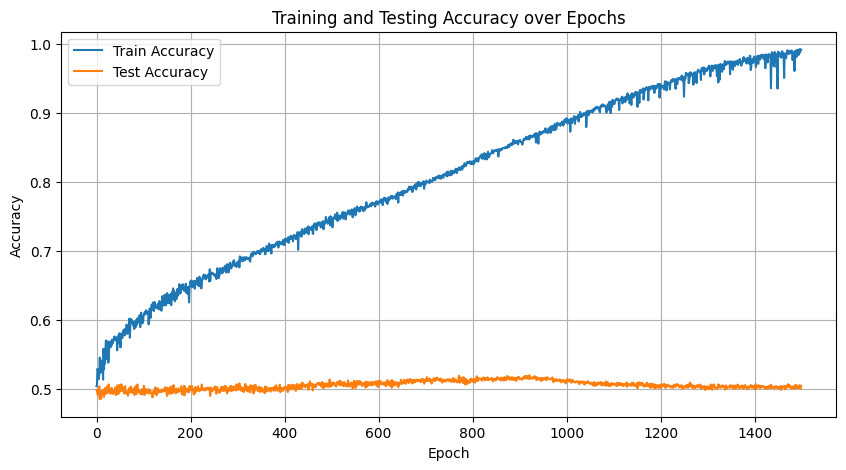

Epoch 1500/1500, Train Accuracy: 0.9920, Test Accuracy: 0.5044


In [ ]:
# 학습 파라미터
batch_size = 100
num_epochs = 1500

train_accuracies = []
test_accuracies = []

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    idxs = np.arange(len(xtrain))
    np.random.shuffle(idxs)

    for batch_cnt in range(0, len(xtrain) // batch_size):
        batch_indices = idxs[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]
        batch_train = xtrain[batch_indices]
        truth_train = ytrain[batch_indices]

        optimizer.zero_grad()
        predictions = model(batch_train)
        loss = loss_func(predictions, truth_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        train_acc = accuracy(model(xtrain), ytrain)
        test_acc = accuracy(model(xtest), ytest)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

    if epoch % batch_size == 0:
        plot_accuracy(train_accuracies, test_accuracies)
        print(f"Epoch {epoch}/{num_epochs}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
plot_accuracy(train_accuracies, test_accuracies)
print(f"Epoch {num_epochs}/{num_epochs}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

최종적으로 학습된 신경망의 정확도를 측정해보자. 학습용 데이터셋과 테스트용 데이터셋을 가지고 각각에 대한 정확도를 측정해보자.


In [ ]:
train_acc = accuracy(model(xtrain), ytrain)
test_acc = accuracy(model(xtest), ytest)
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.9920
Test Accuracy: 0.5044


정확도에 비추어보아, 이 신경망은 성공적인가 아니면 완전한 실패작인가? 테스트용 데이터에 대한 정확도가 학습용 데이터에 대한 정확도보다 현저히 낮게 나왔다면, 무엇이 문제일까? 한 번 생각해보도록 하자.